# Решение задачи классификация на примере воды: пригодная и непригодная для питья на основе её химического состава.

Скачать набор данных можно [здесь](https://lms-cdn.skillfactory.ru/assets/courseware/v1/9cd645af21ef409ff23bf03a783b4b71/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/water_potability.zip). С подробным описанием датасета и столбцов таблицы ознакомьтесь в [источнике](https://www.kaggle.com/datasets/adityakadiwal/water-potability).

Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

In [260]:
import numpy as np # для матричных вычислений 
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации 

from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
plt.style.use('seaborn-v0_8') # стиль отрисовки seaborn
%matplotlib inline

Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

In [261]:
water_data = pd.read_csv('data/water_potability.zip')
water_data.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — **Potability** (пригодность для питья): 1 — вода пригодна, 0 — вода непригодна для питья.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [262]:
water_data.isnull().mean() * 100

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [263]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:

In [264]:
water_data.isnull().mean() * 100

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [265]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

Рассмотрим **основные методы валидации данных** на примере нашего набора данных

### HOLD-OUT

Метод **hold-out (отложенная выборка)** нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Схема разбиения представлена ниже:

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/bd16b00f44056e8a9db9063abd0d7d01/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-2_7.png)

#### ПРЕИМУЩЕСТВА И НЕДОСТАТКИ HOLD-OUT

$+$

* Очень простой и понятный.
* Чаще всего применяется на больших датасетах, так как требует значительно меньше вычислительных мощностей, чем другие методы.

$-$

* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться, и оценка качества может быть необъективной.

#### РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле model_selection, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

**Основные параметры train_test_split()**:

* **arrays* — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
* *test_size* — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.
* *train_size* — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.
* *random_state* — число, на основе которого производится генерация случайных чисел.
* *shuffle* — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
* *stratify* — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

Для примера разделим выборку в соотношении 80/20 (test_size=0.2), в качестве значения параметра random_state по традиции возьмём число 42.

Функция вернёт четыре массива:

* таблицу X с обучающими примерами,
* таблицу X с примерами для валидации,
* столбец y с ответами на обучающие примеры,
* столбец y с ответами на валидационные примеры.

In [266]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

Проверим размеры полученных выборок:

In [267]:
print(f'Train shape: {X_train.shape}')
print(f'Valid shape: {X_valid.shape}')

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid).

В качестве модели будем использовать **дерево решений** с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — *accuracy*.

In [268]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик
print(f'Train hold-out accuracy: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(f'Valid hold-out accuracy: {round(metrics.accuracy_score(y_valid, y_valid_pred), 2)}')

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем **трёхкомпонентный подход** (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию *train_test_split()* дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [269]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
# разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Выводим размерности:

In [270]:
print(f'Train shape: {X_train.shape}')
print(f'Valid shape: {X_valid.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

### K-FOLD

Метод *k-fold* более известен как **кросс-валидация (cross validation)**, или **перекрёстный контроль**.

Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

**Алгоритм кросс-валидации**:

1. Разбить исходную выборку на $k$ частей — **фолдов (fold)**.
2. Повторять $k$ раз:
   * Обучить модель на $k-1$ частях. Назовём их **тренировочными фолдами (training fold)**. 
   * Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её **валидационным фолдом (validation fold)**.
3. Усреднить значения метрики на валидационных фолдах.

Схематично алгоритм кросс-валидации можно представить следующим образом (на рисунке представлена схема работы кросс-валидации с предварительно выделенной для тестирования выборкой):

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/44f5d0d3b5f37b978f455053e2adaec0/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-2_8.png)

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из $k$ частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения $k$ часто берут 10, то есть выборка разбивается на десять фолдов. В случае маленьких выборок $k$ берут равным 3 или 5.

Чем больше $k$, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

#### ПРЕИМУЩЕСТВА И НЕДОСТАТКИ K-FOLD

$+$

* Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.
* Значения метрик получаются более объективными, ведь мы обучаем одну модель  раз — у нас получается  независимых друг от друга значений метрики.

   * **Примечание**. Мы оцениваем метрику не по одному значению на валидационной выборке, как это было в hold-out, а по $k$ значений. Если $k$ достаточно велико, можно даже построить гистограмму и оценить, в каких пределах находится истинное качество. Однако на практике этим занимаются крайне редко, так как такие вычисления очень времязатратны.

$-$

*  Подход предусматривает, что мы обучаем одну и ту же модель $k$ раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

#### РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

В библиотеке *sklearn* метод *k-fold* реализован в классе [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

Основные параметры инициализатора KFold:

* *n_split* — число фолдов (число $k$ из метода *k-fold*). По умолчанию — 5.
* *shuffle* — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
* *random_state* — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

* выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
* обучать дерево решений;
* делать предсказания для текущих тренировочной и валидационной выборок;
* рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [271]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел 
)

# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
# Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
# Организуем цикл для кросс-валидации (используем весь набор данных)
# train_index — индексы тренировочной выборки
# valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    # Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    # Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    # Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    # Pассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

Выведем содержимое массивов train_metrics и val_metrics:

In [272]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [273]:
print(f'Train k-fold mean accuracy: {round(np.mean(train_metrics), 2)}')
print(f'Valid k-fold mean accuracy: {round(np.mean(val_metrics), 2)}')

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики accuracy на кросс-валидации равно 0.81 для тренировочных фолдов и 0.74 — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на валидационных фолдах (если не предусмотрена тестовая выборка). 

**Примечание**. Если количество фолдов больше 30, вы можете построить доверительный интервал для среднего значения метрики.

Согласитесь, сложновато — не совсем в стиле sklearn. Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — [cross_validate()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

* *estimator* — модель, качество которой будет проверяться на кросс-валидации.
* *X* — матрица наблюдений.
* *y* — вектор-столбец правильных ответов.
* *cv* — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* *scoring* — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* *return_train_score* — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* *fit_time* — время обучения модели на каждой итерации кросс-валидации;
* *score_time* — время вычисления метрик на каждой итерации кросс-валидации;
* *test_score* — значения метрик на валидационных фолдах;
* *train_score* — значения метрик на тренировочных фолдах.

**Итоговый код** с использованием функции *cross_validate()* будет выглядеть следующим образом:

In [274]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

cv_metrics

{'fit_time': array([0.01809931, 0.01810551, 0.01690364, 0.01609254, 0.01749063]),
 'score_time': array([0.00195384, 0.0009973 , 0.00099993, 0.00100327, 0.00096345]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [275]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

### LEAVE-ONE-OUT

Метод **leave-one-out (отложенный пример)**, или **поэлементная кросс-валидация** — это частный случай кросс-валидации (k-fold), когда размер $k$ равняется размеру всей выборки $k=n$, где $n$ — количество примеров (строк в таблице).

Алгоритм метода:

1. Повторять  раз:
   * Выбрать один случайный пример для валидации.
   * Обучить модель на всех оставшихся $n-1$ примерах.
   * Произвести оценку качества (вычислить метрику) на отложенном примере.
2. Усреднить значение метрик на всех примерах.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/a7069bfec771f92bbe935126a9e955ad/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-2_10.png)

#### ПРЕИМУЩЕСТВА И НЕДОСТАТКИ LEAVE-ONE-OUT

$+$ 

* Идеально подходит для небольших датасетов (менее 100 примеров).
* Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.

$-$

* Подход предусматривает, что мы обучаем одну и ту же модель $n$ раз. Очевидно, что чем больше примеров в обучающем наборе данных, тем больше моделей мы будем обучать. Поэтому метод не подходит для оценки качества модели на больших наборах данных, поскольку становится очень ресурсозатратным.
   * **Примечание**. Тем не менее в некоторых методах обучения вычисление leave-one-out получается заметно ускорить, и его использование становится возможным.

#### РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

В библиотеке sklearn метод leave-one-out реализован в классе [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html). Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с KFold, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса LeaveOneOut также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

**Примечание**. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

**Итоговый код:**

In [276]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)

# Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()

# Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X.iloc[:500], # матрица наблюдений X
    y=y.iloc[:500], # вектор ответов y
    cv=loo, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

print('Train k-fold mean accuracy {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy 0.95
Valid k-fold mean accuracy: 0.90


**Примечание**. Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

## Дисбаланс выборки

Следующий момент, на который стоит обращать внимание во время построения модели и оценки её качества, — это **дисбаланс выборки**.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/8e51a6f5808178ba97a885a54ef8aff4/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_1.png)

**Несбалансированный набор данных (unbalanced dataset)** — это выборка, в которой количества примеров каждого из классов значительно отличаются.

При этом:

* класс большинства называется **мажоритарным (majority) классом**;
* класс меньшинства называется **миноритарным (minority) классом**.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/2a0f74daffedec4efa5bba77ea826707/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_2.png)

Данное определение дисбаланса очевидно относится к задаче классификации. Понятие дисбаланса есть и в задачах регрессии, но там оно граничит с задачей [поиска аномалий в данных (Anomaly Detection)](https://dyakonov.org/2017/04/19/%D0%BF%D0%BE%D0%B8%D1%81%D0%BA-%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9-anomaly-detection/).

Типичные примеры задач, в которых исследователи чаще всего сталкиваются с дисбалансом выборки: 

* **Обнаружение мошенничества**. Подавляющее большинство (около 90-99 %) транзакций являются немошенническими, а зафиксированных примеров мошенничества — 1-10 %.
* **Обнаружение оттока клиентов**. Подобную задачу мы уже решали в модуле по классификации. Как правило, отток составляет около 10-30 % против 90-70 % лояльных клиентов.
* **Распознавание лиц**. В базе данных лиц вполне стандартной является ситуация, когда в распоряжении может быть 1000 примеров фотографий первого человека против двух-трёх фотографий второго. Легко понять, что опознать второго человека по фотографии будет намного сложнее, чем первого.

**Проблемы, которые могут возникнуть из-за несбалансированной выборки**:

* При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
* Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
* Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Взглянем на соотношение классов внутри датасета:

<Axes: xlabel='Potability', ylabel='count'>

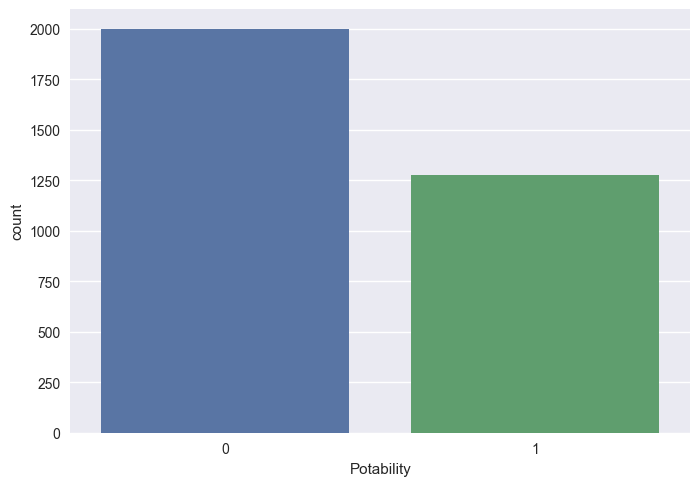

In [277]:
water_data['Potability'].value_counts(normalize=True)
sns.countplot(data=water_data, x='Potability')

Итак, около 61 % образцов воды являются непригодными для питья и 39 % являются пригодными. На самом деле, это небольшой дисбаланс классов (61/39). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например 80/20, 90/10 или даже 99/1. Как работать с такими данными, обсудим далее.

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения *hold-out*, которое мы проводим с помощью функции *train_test_split()*. Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [278]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 57/43. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [279]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', round(y_train.value_counts(normalize=True), 2), sep='')
print('Valid:\n', round(y_valid.value_counts(normalize=True), 2), sep='')

Train:
0    0.61
1    0.39
Name: Potability, dtype: float64
Valid:
0    0.61
1    0.39
Name: Potability, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — 61/39. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

**А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?**

Для этого вместо KFold используется кросс-валидатор [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [280]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate().

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:

<Axes: xlabel='feature_1', ylabel='feature_2'>

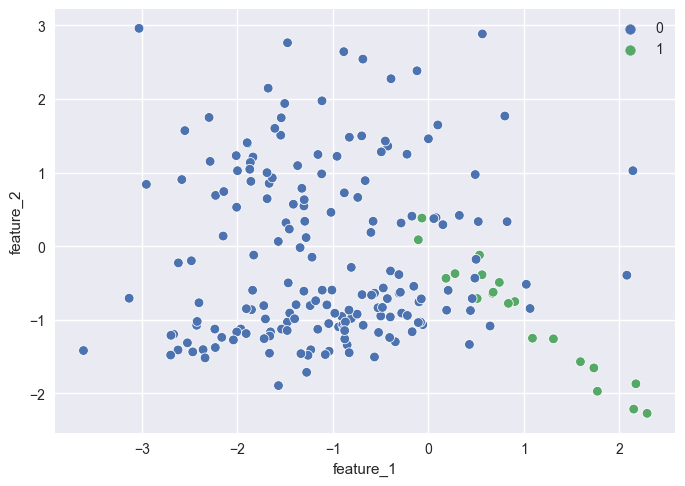

In [281]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)

Разбейте исходный набор данных на тренировочный и валидационный **со стратификацией** по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

<Axes: xlabel='feature_1', ylabel='feature_2'>

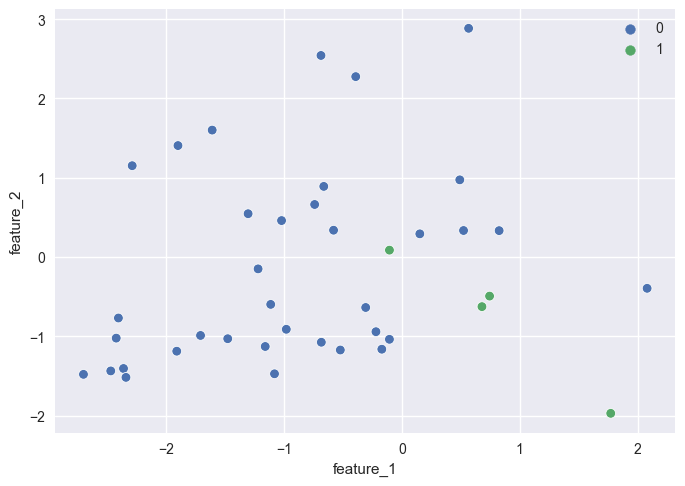

In [282]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y)

### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам accuracy, доля угаданных моделью ответов. Вспомним её формулу:

$accuracy = {{TP + TN} \over {TP + TN + FN + FP}}$,

где:

* *True Positive (TP)* — количество ответов, которые обозначены моделью как класс 1 ($\hat y = 1$) и действительно относящиеся к классу 1 ($y = 1$).
* *False Positive (FP)* — количество ответов, которые обозначены моделью как класс 1 ($\hat y = 1$), но в действительности относящиеся к классу 0 ($y = 0$).
* *False Negative (FN)* — количество ответов, которые обозначены моделью как класс 0 ($\hat y = 0$), но в действительности относящиеся к классу 1 ($y = 1$).
* *True Negative (TN)* — количество ответов, которые обозначены моделью как класс 0 ($\hat y = 0$), и действительно относящиеся к классу 0 ($y = 0$).

Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам precision, recall и $F_1$-score.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [283]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

* *Precision* для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
* *Recall* для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
* *$F_1$-мера* — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

Примечание. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать [здесь](https://dyakonov.org/2019/05/31/%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8B-%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0-%D0%B2-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5-%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD/).

Обучитм модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделаем предсказание для валидационной выборки и рассчитаем метрики классификации. Ответ округлим до двух знаков после точки-разделителя.

In [284]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

In [285]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    

<Axes: xlabel='feature_1', ylabel='feature_2'>

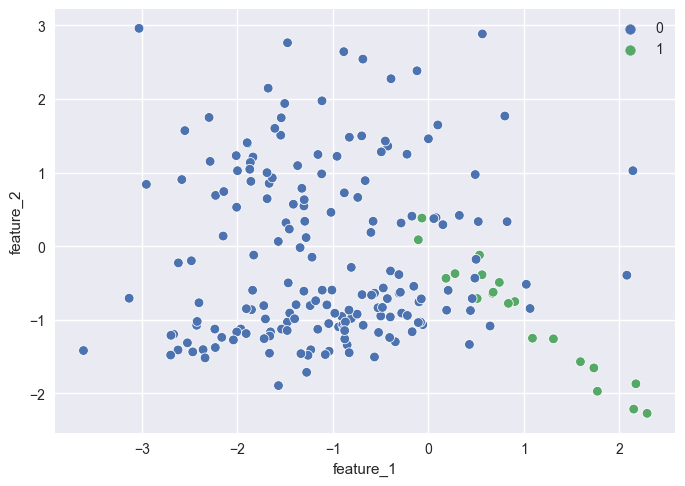

In [286]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)

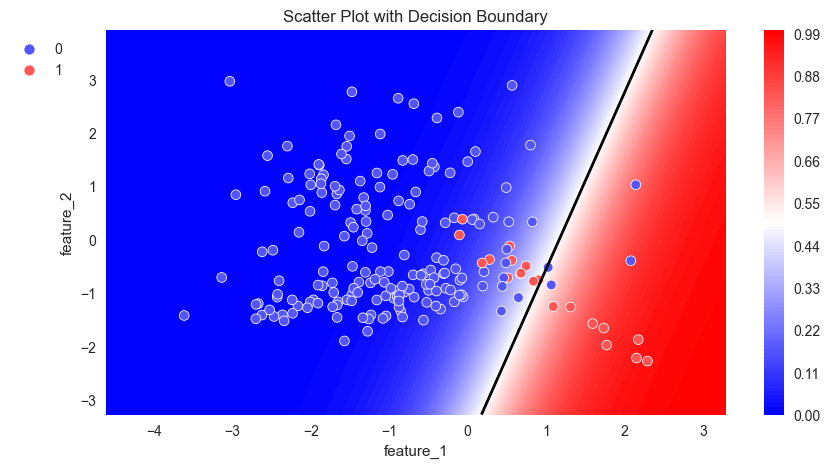

In [287]:
plot_probabilities_2d(X, y, log_reg)

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Итак, мы посмотрели, как дисбаланс выборки может оказывать влияние на способность модели находить класс меньшинства. Но как с этим бороться?

Существует **несколько способов уменьшить влияние дисбаланса на обучение модели**:

* **Взвешивание объектов**. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
* **Выбор порога вероятности**. Подход заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, $F_1$-score).
* **Сэмплирование (sampling)** — перебалансировка выборки искусственным путём:
   * **oversampling** — искусственное увеличение количества объектов миноритарного класса;
   * **undersampling** — сокращение количества объектов мажоритарного класса.
   ![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/159104a78a3a9b7e007d706ecc0a0aae/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_14.png)

   Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic). Мы рассмотрим наиболее популярный алгоритм — **SMOTE**, об остальных можно прочитать [здесь](https://dyakonov.org/2021/05/27/imbalance/).

#### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

$class \ weight (majority) = 1,$

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

$class \ weight (minority) = {1 + {n_{minority} \over n_{majority}}},$

где $n_{minority}$ и $n_{majority}$ число — объектов в миноритарном и мажоритарном классах соответственно. Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений:

In [288]:
# Создаем модель 
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)
# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик  
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



Так гораздо лучше! Обратите внимание на метрики класса 1: значение $F_1$ поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

In [289]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
log_reg_balanced = linear_model.LogisticRegression(class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)
y_valid_pred = log_reg_balanced.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



<Axes: xlabel='feature_1', ylabel='feature_2'>

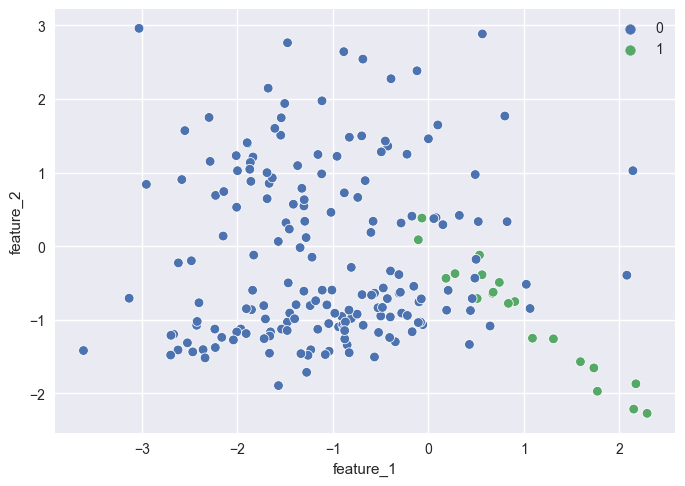

In [290]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)

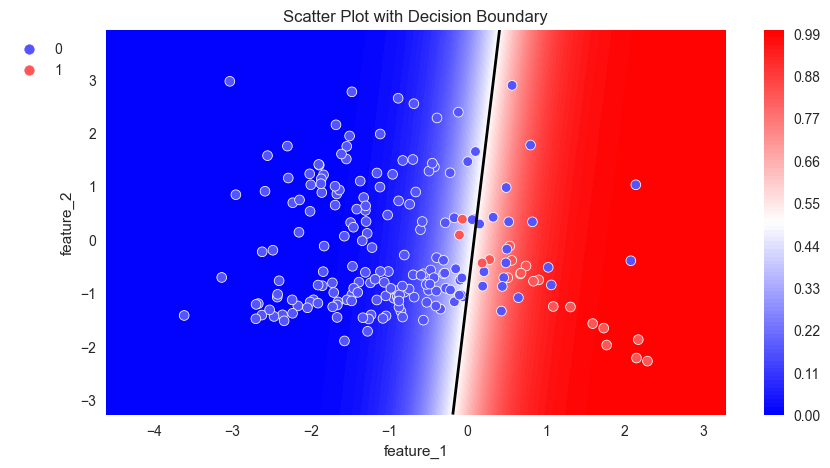

In [291]:
plot_probabilities_2d(X, y, log_reg_balanced)

#### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

Следующий метод — это выбор **порога вероятности (бинаризации)**.

Мы знаем, что любой классификатор предсказывает для объектов вероятности их принадлежности к классу 1 ($\hat P$) и классу 0 ($Q = 1 - \hat P$). Класс объекта по умолчанию определяется по следующему правилу:

* Если вероятность $\hat P > 0.5$, то объект относится моделью к классу 1.
* Если вероятность $\hat P \leq 0.5$, то объект относится моделью к классу 0.

Однако, данный порог можно поменять и сделать его равным, например, 0.15 или 0.7. Это является очень распространённой практикой, ведь для каждой задачи может быть свой оптимальный порог вероятности.

**PR-кривая (precision-recall curve)** — это график зависимости precision от recall при различных значениях порога вероятности.

Для построения данного графика мы берём множество различных порогов вероятности (0.1, 0.15, 0.2, …1) и вычисляем метрики precision и recall при разных порогах вероятности. Если мы построим линейный график зависимости precision от recall, то получим примерно следующую картину:

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/c16f93c061dc44bb1abb408955293e94/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_17.png)

Подписи к точкам на графике — пороги вероятности.

**Что нам даёт такая кривая?**

1. 
Во-первых, PR-кривая — это графическая метрика качества модели, она комплексно отражает и *precision*, и *recall* одновременно (как $F_1$-мера) и особенно хороша в условиях дисбаланса классов.

Качество определяется площадью (*PR AUC*) под кривой: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь равна 1. У такой модели и *precision*, и *recall* равны 1. Конечно же, таких моделей не существует в природе.

Если площадь под PR-кривой меньше 0.5, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/fbb4d1fe33c7c341c4d9ba3d5e6f95eb/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_18.png)

По площади под PR-кривой мы можем сравнивать модели между собой.

Например, ниже изображены PR-кривые для логистической регрессии (Logistic Regression) и случайного леса (Random Forest). Площадь под первой кривой — 0.680, под второй — 0.688. Можно сделать вывод, что с небольшим отрывом на тысячных долях побеждает случайный лес.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/dd19281c80ccc7e9380e13b8d8a5528c/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_19.png)

2. 
Во-вторых, с помощью PR-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение precision или recall или среднее гармоническое между ними ($F_1$-score). 

Подберём порог вероятности с помощью *PR*-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики $F_1 = {2 \ * \ precision \ * \ recall \over (recall \ + \ precision)}$ для класса 1 (питьевая вода).

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию [cross_val_predict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр *method='predict_proba'*, она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции *cross_validate()*.

In [292]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



In [293]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел 
)
# Обучаем модель
model.fit(X_train, y_train)
# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [294]:
# Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]
y_cv_proba_pred

array([1.        , 0.75438596, 0.        , ..., 0.39378238, 0.        ,
       0.96969697])

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) из модуля *metrics* библиотеки *sklearn*. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик *precision* и *recall*, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [295]:
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:', recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение $F_1$-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции [argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума $F_1$-score.

Best threshold = 0.33, F1-Score = 0.69


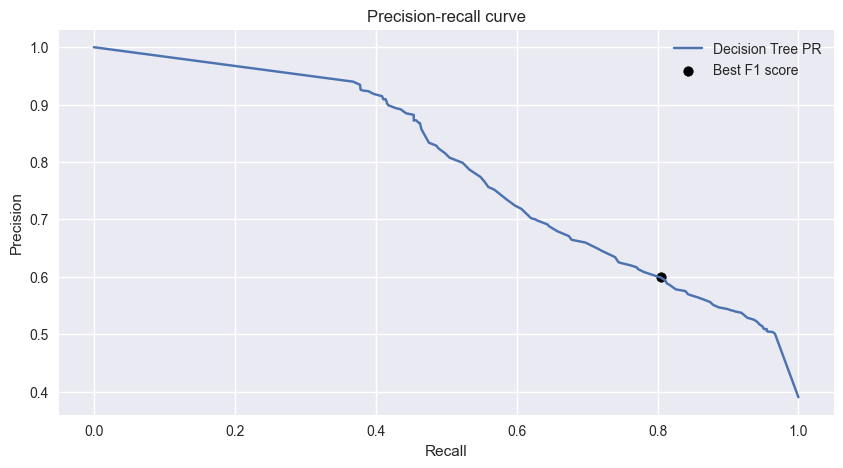

In [296]:
# Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимума
idx = np.argmax(f1_scores)
print(f'Best threshold = {thresholds[idx]:.2f}, F1-Score = {f1_scores[idx]:.2f}')

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
# Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум $F_1$ (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [297]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.33
# Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
# В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
# Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Итак, при применении метода подбора вероятности увеличилось значение метрик *recall* и $F_1$ для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

Примечание. Чтобы вычислить площадь под *PR*-кривой, используется функция [auc()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) из модуля *metrics* библиотеки *sklearn*. В данную функцию нужно передать значения метрик *recall* и *precision* при различных порогах вероятности:

In [298]:
print(f'PR AUC: {metrics.auc(recall, precision):.2f}')

PR AUC: 0.79


#### СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов — **сэмплирование**, а точнее — **пересэмплирование (oversampling)**.

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/8ea33849ae5b8385fdceff87757af7a0/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_24.png)

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм **SMOTE (Synthetic Minority Oversampling Techniques)**.

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/02063e1a7fa805302ded1c879f1b7575/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/dst3-ml5-3_30.gif)

Тем, кто заинтересуется математической составляющей методов сэмплирования, советуем заглянуть в [эту статью](https://basegroup.ru/community/articles/imbalance-datasets) — в ней описаны различные стратегии сэмплирования, включая алгоритм *SMOTE*.

Алгоритмов сэмплирования, в том числе *SMOTE*, нет в стандартном пакете *sklearn* — они содержатся в библиотеке *imblearn (imbalanced-learn)*. Команды для установки приведены далее.

In [299]:
# Для пользователей pip:

! pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [300]:
# Для пользователей anaconda:

# !conda install -c conda-forge imbalanced-learn

Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:

In [301]:
from imblearn.over_sampling import SMOTE

Примечание. Если вы используете среду Anaconda, у вас может возникнуть следующая ошибка при импорте библиотеки imblearn:

ImportError: cannot import name '_euclidean_distances' from 'sklearn.metrics.pairwise'
В этом случае обновите пакеты Anaconda:

conda update conda
После этого произведите установку пакета ещё раз:

!conda install -c conda-forge imbalanced-learn

Создадим объект класса *SMOTE* и вызовем у него метод *fit_resample()*, передав в него обучающую выборку *(X_train, y_train)*. Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [302]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape)
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-' * 40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


Итак, размер выборки увеличился с 2620 примеров до 3196, и теперь количество наблюдений каждого из классов одинаково (1598/1598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [303]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
# Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Нам удалось поднять метрики для класса 1 на валидационной выборке и снова найти баланс между метриками классов. Однако мы потеряли в метриках для класса 0.

In [304]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



In [305]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел 
)
# Обучаем модель
model.fit(X_train, y_train)
# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [306]:
# Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]
y_cv_proba_pred

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.55555556,
       0.55555556, 0.55555556, 0.55555556, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.25      , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [307]:
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:', recall[:5])

Thresholds: [0.         0.16666667 0.25       0.28571429 0.5       ]
Precision scores: [0.1        0.48275862 0.5        0.59090909 0.61904762]
Recall scores: [1.     0.875  0.875  0.8125 0.8125]


Best threshold = 0.56, F1-Score = 0.74


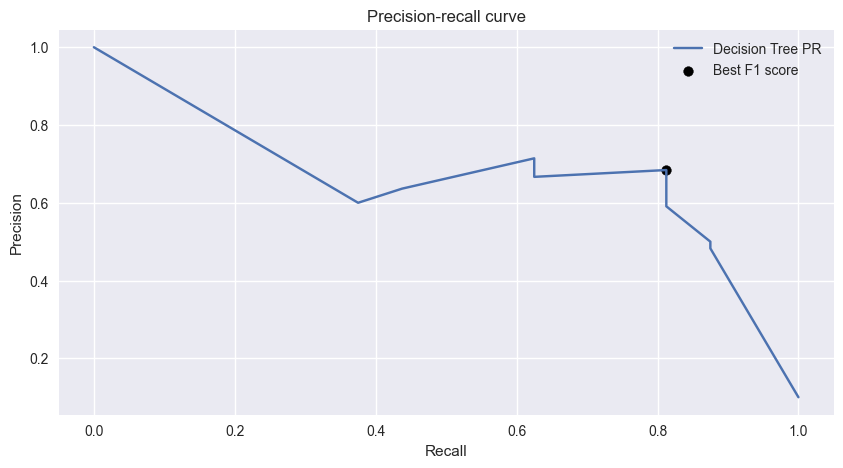

In [308]:
# Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимума
idx = np.argmax(f1_scores)
print(f'Best threshold = {thresholds[idx]:.2f}, F1-Score = {f1_scores[idx]:.2f}')

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
# Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

In [309]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.56
# Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
# В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
# Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



In [310]:
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape)
#print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-' * 40)
print('Train shape after oversampling:', X_train_s.shape)
#print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
----------------------------------------
Train shape after oversampling: (288, 2)


In [311]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
# Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



In [312]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics 
import pandas as pd
from imblearn.over_sampling import SMOTE

X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
log_reg_smote = linear_model.LogisticRegression(class_weight='balanced')
log_reg_smote.fit(X_train_s, y_train_s)
y_valid_pred = log_reg_smote.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



C:\Users\Lida\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


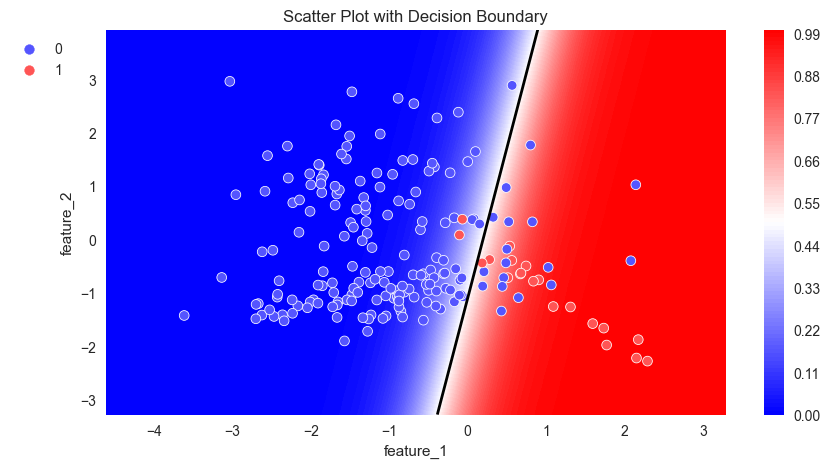

In [313]:
plot_probabilities_2d(X, y, log_reg_smote)

Заметьте, что качество всех рассмотренных методов приблизительно одинаковое — они дают примерно идентичное значение метрик. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.

На самом деле плохая различающая способность может быть связана не только с дисбалансом выборки. На качество моделирования влияют и другие факторы:

* **Сложность модели**. Выбранная нами модель дерева решений является довольно простым классификатором. Имеет смысл задуматься над применением более сложных методов, например случайного леса.
* **Недостаток информации**. Вполне возможно, признаков, описывающих химический состав воды, попросту недостаточно, чтобы точно сказать, пригодна ли она для питья.
* **Качество данных**. В представленных данных возможно наличие зашумлённой информации — выбросов и аномальных образцов воды.

В заключение отметим важный момент: дисбаланс — это **не проблема**, а свойство данных. Проблемами в данном случае будут неправильное формирование выборок, использование необъективных метрик и отсутствие учёта дисбаланса при построении моделей. Сам дисбаланс является только условием, в котором возникают перечисленные проблемы.

От самого дисбаланса в большинстве случаев никуда не деться без проведения новых экспериментов: в примере с мошенническими транзакциями вы не можете увеличить количество мошенников, а в примере с оттоком клиентов — количество уходящих клиентов (искусственное увеличение не в счёт). Это важно понимать.

Если ваша модель по определению является слабой и не способна выделить сложные зависимости, то, как бы вы ни старались минимизировать дисбаланс, это не принесёт качественных результатов. В таком случае вам следует взять более сложную модель или увеличить количество данных.

Полезно помнить: хорошие признаки и правильно подобранная модель — вот что самое главное в ML. Всё остальное — второстепенно.